## Install the following libraries, if not done already, before running the below script

#### !pip install tensorflow
#### !pip install scikit-learn
#### !pip install numpy 
#### !pip install pandas 
#### !pip install pyDOE 
#### !pip install scipy
#### !pip install matplotlib
#### !pip install pypickle

In [ ]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit
import pickle


# Ensure reproducibility
np.random.seed(42)
tf.random.set_random_seed(42)


# Material constants
E = 192000e6  # Young's modulus in MPa
sigma_y = 110e6  # Yield stress in MPa
h = 7  # Isotropic hardening rate

def generate_strain_history(lb, ub):

    strain_history = np.zeros(3900)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = 0.0001
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, 1600):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    for i in range(1600, 2300):
        increment = 0.0001
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain
    
    for i in range(2300, 3100):
        increment = 0.0001
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
        
    for i in range(3100, 3900):
        increment = 0.0001
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    return strain_history
    
    
# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, h, alpha, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    yield_function = np.abs(sigma_trial) - (sigma_y + h * alpha)
    return sigma_trial, yield_function


# Von Mises return mapping algorithm
def von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        sigma_updated = sigma_trial
        eps_p = eps_p
        alpha = alpha
        delta_gamma=0
        sign = sigma_trial/np.abs(sigma_trial)
    else:
        # Plastic step
        delta_gamma = yield_function / (E + h)
        eps_p = eps_p + delta_gamma* (sigma_trial/np.abs(sigma_trial))
        alpha = alpha + delta_gamma
        #sigma_updated = sigma_trial - E * delta_gamma
        sigma_updated = E*(eps-eps_p)
        sign = sigma_trial/np.abs(sigma_trial)

    return sigma_updated, eps_p, alpha, delta_gamma, sign


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(lb, ub)

    # Initialize state variables
    alpha, eps_p, delta_gamma = 0, 0, 0
    
    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, h, alpha, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, alpha, delta_gamma, sign  = von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y)

        # Store the data
        dataset.append([
            E,sigma_y,h, yield_function, eps, sigma_updated, eps_p, alpha, sign, np.abs(delta_gamma)
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_von_mises_training_07_01_2025.csv"):
    columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cummulative eps_p", "alpha",'sign', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")


In [17]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [18]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [19]:
training[:,4]

array([ 0.0001,  0.0002,  0.0003, ..., -0.0298, -0.0299, -0.03  ])

In [20]:
training[-1]

array([ 1.92000000e+11,  1.10000000e+08,  7.00000000e+00,  1.92000000e+07,
       -3.00000000e-02, -1.10000003e+08, -2.94270833e-02,  3.83697917e-01,
       -1.00000000e+00,  1.00000000e-04])

In [21]:
with open('scaler_X_von_mises_20_01_2025.pkl', 'rb') as file:
    scaler_X = pickle.load(file)

with open('scaler_y_von_mises_20_01_2025.pkl', 'rb') as file:
    scaler_y = pickle.load(file)

In [22]:
columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cumulative_plastic_strain", "alpha", 'sign','plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [23]:
df=df.fillna(1)

In [24]:
df.isna().sum()

E                            0
sigma_y                      0
h                            0
yield_function               0
strain                       0
sigma_updated                0
cumulative_plastic_strain    0
alpha                        0
sign                         0
plastic_strain               0
dtype: int64

In [25]:
# Separate features and target
X = df.iloc[:, :4]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = df.iloc[:, -1]  # Targets (plastic_strain)

In [26]:
X_normalized = scaler_X.transform(X)
y = y.values.reshape(-1, 1)
y_normalized = scaler_y.transform(y)

In [27]:
model= tf.keras.models.load_model('plastic_strain_predictor_model_von_mises_20_01_2025.h5')

In [28]:
y_pred_normalized = np.abs(model.predict(X_normalized))

In [29]:
y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized)

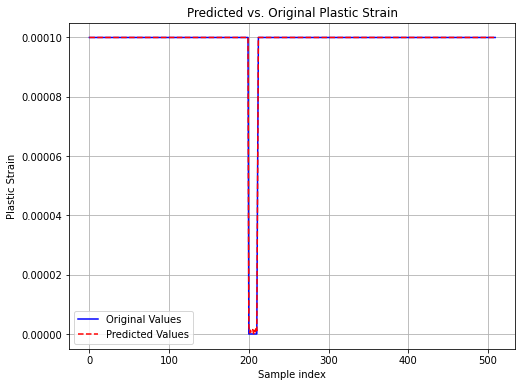

Plot saved as predicted_vs_actual


In [30]:
plot_predicted_vs_actual(y[100:610], y_pred_denormalized[100:610], filename='predicted_vs_actual.png')

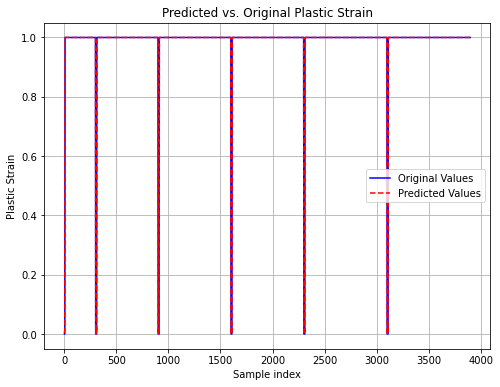

Plot saved as predicted_vs_actual


In [31]:
plot_predicted_vs_actual(y_normalized, y_pred_normalized, filename='predicted_vs_actual.png')

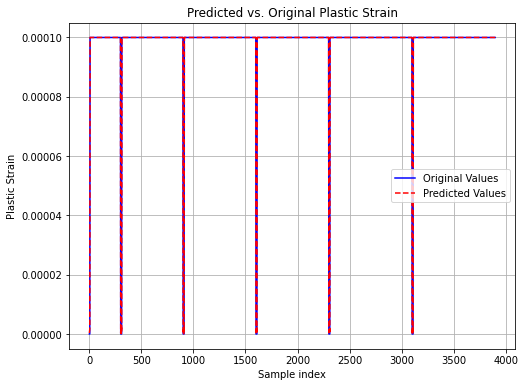

Plot saved as predicted_vs_actual


In [32]:
plot_predicted_vs_actual(y, y_pred_denormalized, filename='predicted_vs_actual.png')

In [33]:
signs = df.iloc[:,-2]

In [34]:
signs[650:700]

650   -1.0
651   -1.0
652   -1.0
653   -1.0
654   -1.0
655   -1.0
656   -1.0
657   -1.0
658   -1.0
659   -1.0
660   -1.0
661   -1.0
662   -1.0
663   -1.0
664   -1.0
665   -1.0
666   -1.0
667   -1.0
668   -1.0
669   -1.0
670   -1.0
671   -1.0
672   -1.0
673   -1.0
674   -1.0
675   -1.0
676   -1.0
677   -1.0
678   -1.0
679   -1.0
680   -1.0
681   -1.0
682   -1.0
683   -1.0
684   -1.0
685   -1.0
686   -1.0
687   -1.0
688   -1.0
689   -1.0
690   -1.0
691   -1.0
692   -1.0
693   -1.0
694   -1.0
695   -1.0
696   -1.0
697   -1.0
698   -1.0
699   -1.0
Name: sign, dtype: float64

In [35]:
y_pred_denormalized.shape

(3900, 1)

In [36]:
y_pred_denormalized

array([[3.3091305e-07],
       [9.9265571e-07],
       [1.0648370e-06],
       ...,
       [1.0000535e-04],
       [1.0000535e-04],
       [1.0000535e-04]], dtype=float32)

In [37]:
y_pred_denormalized = np.squeeze(y_pred_denormalized)

In [38]:
y_pred_denormalized.shape

(3900,)

In [39]:
y_pred_denormalized_signed = np.abs(y_pred_denormalized) * signs

In [40]:
#y_pred_denormalized_signed=y_pred_denormalized_signed.flatten()[:4500]

In [41]:
y_pred_denormalized_signed

0       3.309131e-07
1       9.926557e-07
2       1.064837e-06
3       1.256359e-06
4       1.779544e-06
            ...     
3895   -1.000054e-04
3896   -1.000054e-04
3897   -1.000054e-04
3898   -1.000054e-04
3899   -1.000054e-04
Name: sign, Length: 3900, dtype: float64

In [42]:
cumulative_sum_list1 = np.cumsum(y_pred_denormalized_signed)

In [43]:
cumulative_sum_list1

0       3.309131e-07
1       1.323569e-06
2       2.388406e-06
3       3.644764e-06
4       5.424309e-06
            ...     
3895   -2.901730e-02
3896   -2.911731e-02
3897   -2.921731e-02
3898   -2.931732e-02
3899   -2.941732e-02
Name: sign, Length: 3900, dtype: float64

In [44]:
stress_nn= 192000e6*(training[:,4]-cumulative_sum_list1)

In [45]:
signs = df.iloc[:,-2]

In [46]:
y_denormalized_signed = np.abs(np.squeeze(y)) * signs

In [47]:
cumulative_sum_list2 = np.cumsum(y_denormalized_signed)

In [48]:
stress_rm= 192000e6*(training[:,4]-cumulative_sum_list2)

In [49]:
stress_nn

0       1.913646e+07
1       3.814587e+07
2       5.714143e+07
3       7.610021e+07
4       9.495853e+07
            ...     
3895   -1.118781e+08
3896   -1.118771e+08
3897   -1.118761e+08
3898   -1.118751e+08
3899   -1.118740e+08
Name: sign, Length: 3900, dtype: float64

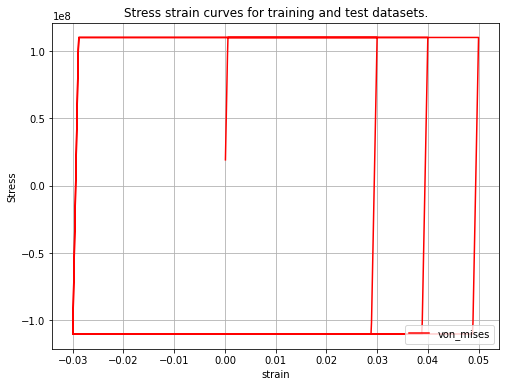

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], stress_rm, label='von_mises', color='red')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

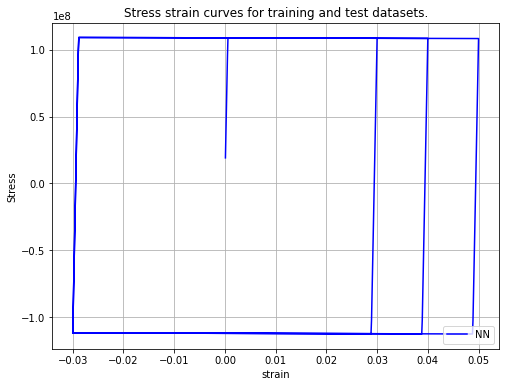

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

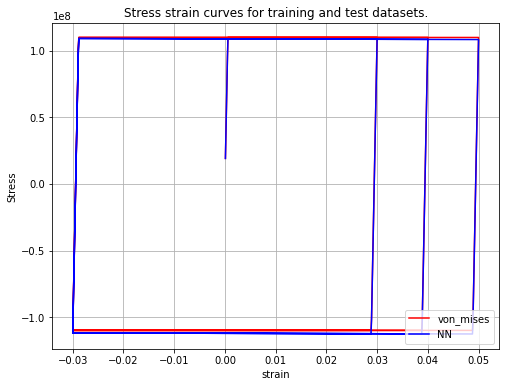

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], stress_rm, label='von_mises', color='red')
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

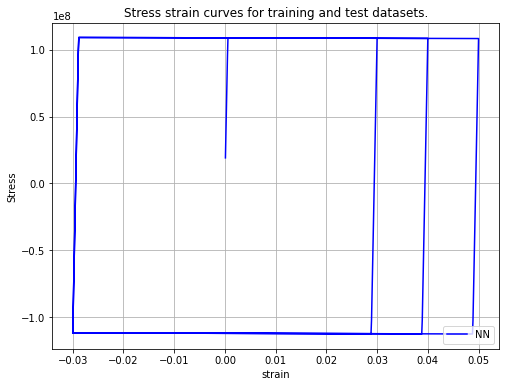

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

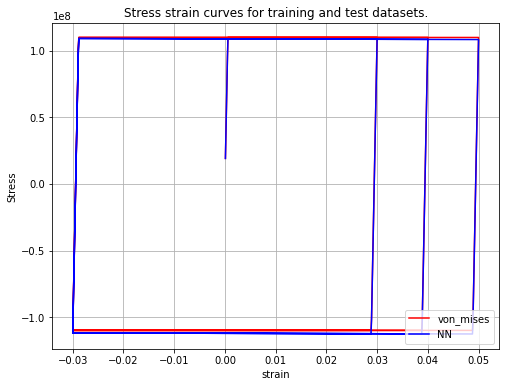

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], stress_rm, label='von_mises', color='red')
plt.plot(training[:,4], stress_nn, label='NN', color='blue')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()